## Abstract

The discovery of conservation principles is crucial for understanding the underlying behavior of physical systems and has applications across various domains. In this paper, we propose a novel method that combines representation learning and topological analysis to uncover the topology of conservation law spaces. Our approach is robust, as it does not rely on expert-selected values of hyperparameters, making it accessible to researchers from different disciplines. We demonstrate the method's effectiveness on a set of physical simulations, showcasing its potential for uncovering previously unknown conservation principles and fostering interdisciplinary research. Ultimately, this work emphasizes the power of data-driven techniques in advancing our understanding of fundamental principles governing physical systems and beyond.

## Methods

### Data

In our work we learn to determine the number of conserved quantities in dynamical system using the data from trajectories of this system. For a given model we consider a dataset of $N_traj$ trajectories, where each trajectory is represented by $traj_len$ points in the phase space. Initial conditions for the trajectories are drawn randomly from the phase space. Our algorithm only works under the assumption that the time of sampling is sufficiently large, such that any two trajectories with equal conserved quantities will draw from a single distribution which depend only on the values of the conserved quantities and not on the specific initial condition. The property of the system to have such sufficiently large time is called ergodicyty, so we consider only ergodic systems.


### Algorithm

We start the algorithm with normalizing the data to have the zero mean and unit variance along each individual coordinate of the phase space. To the resulting rescaled trajectories we apply the Wasserstein distance to compute pairwise distances between trajectories. These pairwise distances approximate the metric sctructure of the manifold $\mathcal{C}$ consisting of all possible trajectories of the system. Then we construct a series of embeddings in spaces with different dimensions using the UMAP algorithm. For each embedding we compute a score measuring how different the metric structure in the embedding differs from the metric structure given by the Wasserstein distances. The minimal dimension where the score is low corresponds to the dimensionality of the manifold $\mathcal{C}$. Moreover, $\mathcal{C}$ can be parametrised by the values of conserved quantities, so its dimensionality equals to the number of conserved quantities. Therefore, our algorithm is able to find the number of conserved quantities in the system.


## Algorithm pipeline showed on the example system, coupled oscillator 

In [1]:
import warnings
import numba


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=numba.NumbaDeprecationWarning)


import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from creating import create_trajectories
from utils import gen_dist_matrix, circle_metric, normalize_angle, circle_metric_without_grad, OrderScore, plot_scores, plot_score_diffs, plot_all_2d, get_stop_point, plot_1d
import umap
from functools import partial

Defining the hypreparameters of the algorithm

In [2]:
n_epochs_1d = 10000
n_neighbors_frac = 0.5
max_dim = 6
n_reference = 40
n_nearest_frac = 0.25
threshold = 0.01


The algorithm starts with loading the data points from trajectories and normalazing it such that along each coordinate the data has zero mean and unit variance

raw data:


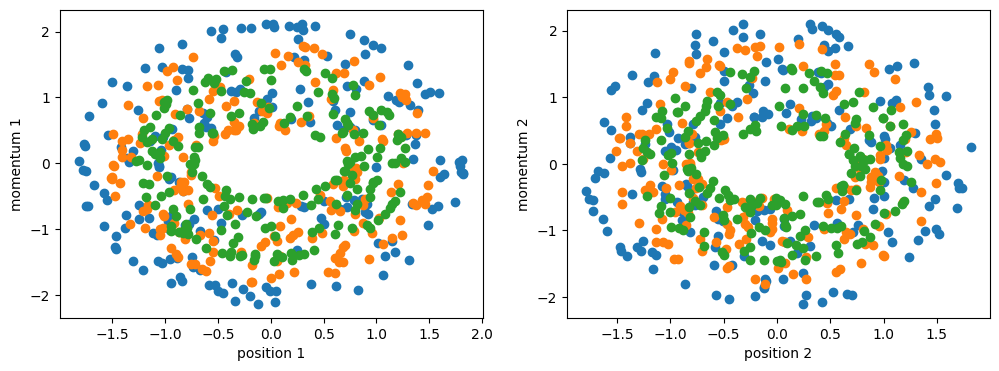

normalized data:


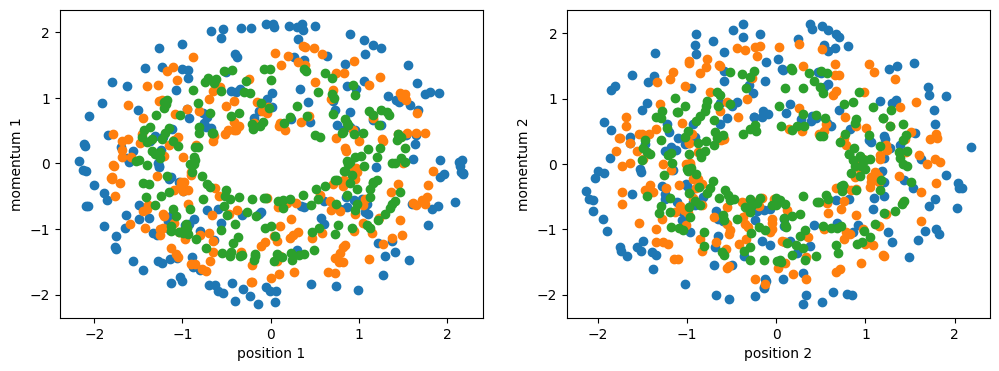

In [3]:
N_plotted = 3


def plot_co(data):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for i in [0, 1]:
        for traj in data[:N_plotted]:
            ax[i].scatter(*traj[:, [i, 2 + i]].T)
        ax[i].set_xlabel(f"position {i + 1}")
        ax[i].set_ylabel(f"momentum {i + 1}")
    plt.show()


coupled_oscillator = np.load("data/coupled_oscillator.npz")
data_co = coupled_oscillator["data"] # data_co is a np.ndarray of shape (n_trajectories, trajectory_length, state_length)
params_co = coupled_oscillator["params"] # conserved quantities computed theoretically

print("raw data:")

plot_co(data_co)


data_co = StandardScaler().fit_transform(np.concatenate(list(data_co))).reshape(data_co.shape)

print("normalized data:")

plot_co(data_co)

The next step of the algorithm is to compute the Wasserstein distances between trajectories and get a distance matrix

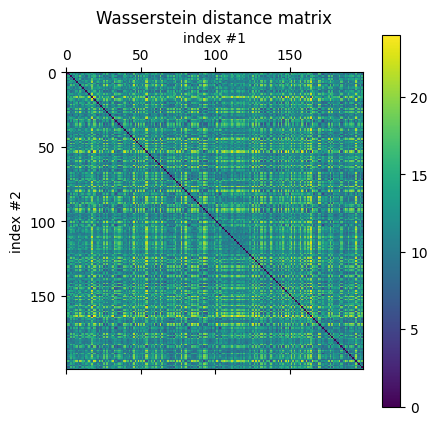

In [4]:
dmat_co = gen_dist_matrix(data_co, verbosity=0)


plt.matshow(dmat_co)
plt.title("Wasserstein distance matrix")
plt.gca().xaxis.set_label_position('top') 
plt.xlabel("index #1")
plt.ylabel("index #2")
plt.colorbar()
plt.show()


Using the Wasserstein distance matrix we can compute a sequence of UMAP embeddings

In [5]:
embeddings = []


UMAP = partial(umap.UMAP, n_neighbors=int(n_neighbors_frac * len(dmat_co)), metric="precomputed")

periodic_embedding = UMAP(n_components=1,
                          output_metric=circle_metric,
                          n_epochs=n_epochs_1d).fit_transform(dmat_co)
periodic_embedding = np.vectorize(normalize_angle)(periodic_embedding)
embeddings.append(periodic_embedding)

for n_components in range(1, max_dim + 1):
    if n_components == 1:
        embedding = UMAP(n_components=n_components, n_epochs=n_epochs_1d).fit_transform(dmat_co)
    else:
        embedding = UMAP(n_components=n_components).fit_transform(dmat_co)
    embeddings.append(embedding)

For each embedding we compute the score measuring how much the metric stricture in the embedding deviates from the metric structure given by the Wasserstein distance

In [6]:
order_score = OrderScore(dmat_co, n_reference, int(n_nearest_frac * len(dmat_co)))

scores = []
errors = []

score, error = order_score.order_score(embeddings[0], output_metric=circle_metric_without_grad)
scores.append(score)
errors.append(error)

for embedding in embeddings[1:]:
    score, error = order_score.order_score(embedding)
    scores.append(score)
    errors.append(error)

Now we can take a look on the scores and score differences to understand the results.

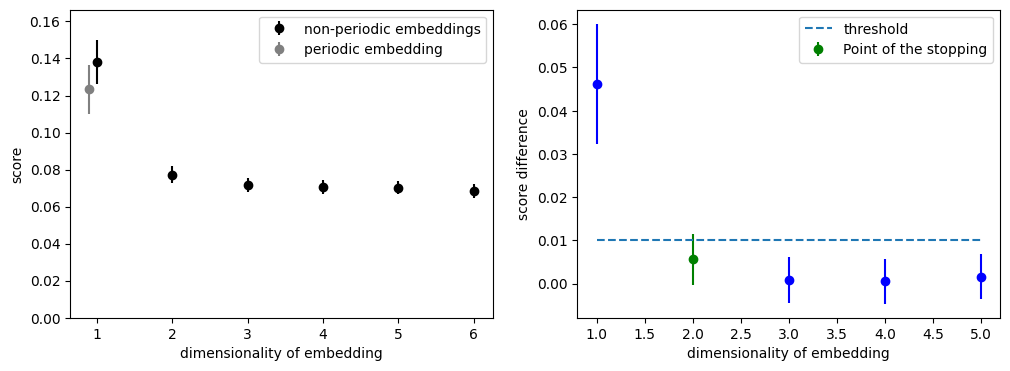

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

predicted_n_conserved = get_stop_point(scores, threshold)

plot_scores(ax1, scores, errors)
plot_score_diffs(ax2, scores, errors, predicted_n_conserved, threshold)

The first time the score difference is lower than the threshold is between the second and third score. This means that the algorithm predicts two conserved quantities in the system.

We can check that the UMAP was not able to embed trajectories with similar energies into neighboring points in 1d, but it was able to do so in 2d

1d embedding:


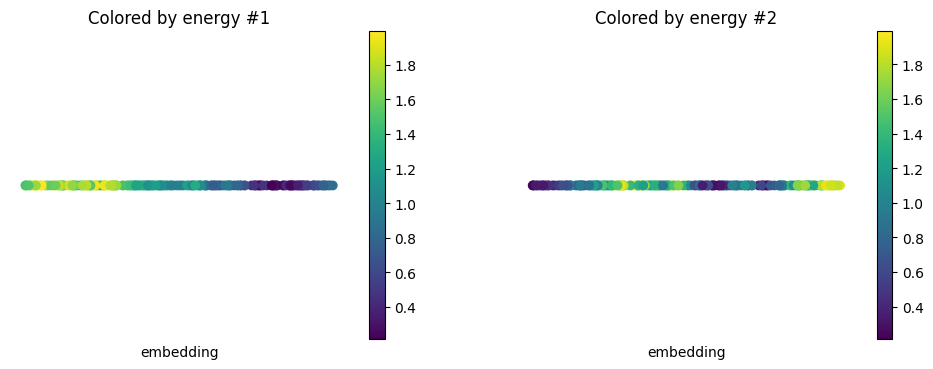

2d embedding:


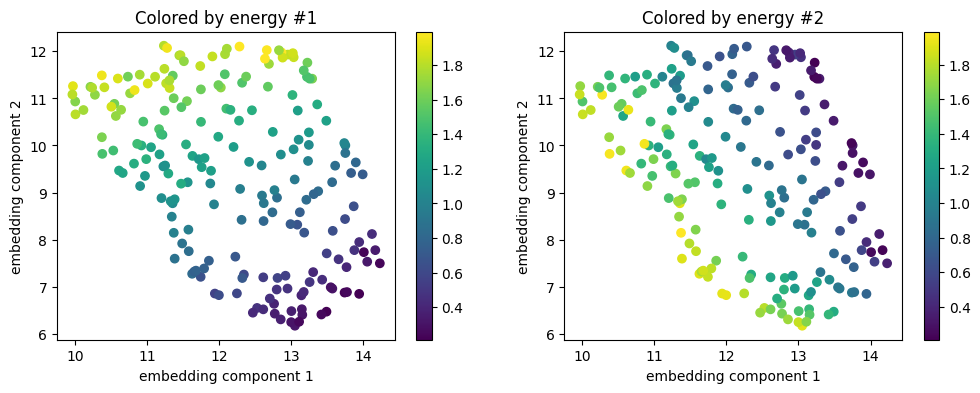

In [8]:
print("1d embedding:")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_1d(fig, ax1, embeddings[1], params_co[:, 0], "energy #1")
plot_1d(fig, ax2, embeddings[1], params_co[:, 1], "energy #2")

plt.show()


print("2d embedding:")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_all_2d(fig, ax, embeddings[2], params_co, ["energy #1", "energy #2"])

plt.show()

## Conclusion

Our method for discovering conservation principles highlights the potential of integrating data-driven techniques to uncover and understand the conservation laws influencing physical systems. By pairing representation learning with topological analysis, we've crafted a robust, accessible approach that doesn't rely on expert-selected hyperparameters, and is versatile across numerous disciplines.

Although the initial experiments using simple physical systems suggest a diverse applicability of this approach, which ranges from robotics and advanced physical system simulation to material science and beyond, we acknowledge the limitations outlined by the reviewer. It is important to note that conclusions about these complex systems should be made cautiously and our success in revealing unknown conservation principles in these simpler systems merely indicates the potential of our method for interdisciplinary research, rather than a definitive success with more intricate systems.

As our method continues to evolve, it is our goal to enhance its capability to elucidate complex conservation laws and principles. We remain committed to the rigorous, evidence-based development of our approach, continually striving for a better understanding of the conservation principles that govern the diverse systems that shape our world. This pursuit, however, is understood to be a complex task - one that requires a careful balance of aspiration and grounded scientific inquiry.

## Outcome

* Applied for the patent of the algorithm
* Paper for the conference is in progress
